In [869]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1
## Question 1.1

In [870]:
A = [1,-2.438, 1.942,-0.502]
B = [1.446,-0.158,-1.093]
k = 1

In [871]:
# Solve diophantine
def solve_diophantine(A,C,m):
    G = []
    S = C[:] + [0 for _ in range(len(A)-len(C))]

    for i in range(m):
        G.append(S[0])
        S = [S[j] - S[0] * A[j] for j in range(1, len(S))] + [0]

    S = S[:-1]
    return S, G

S, G = solve_diophantine(A,[1],m=1)
print('S =',S)
print('G =',G)
BG = np.convolve(G, B)

S = [2.438, -1.942, 0.502]
G = [1]


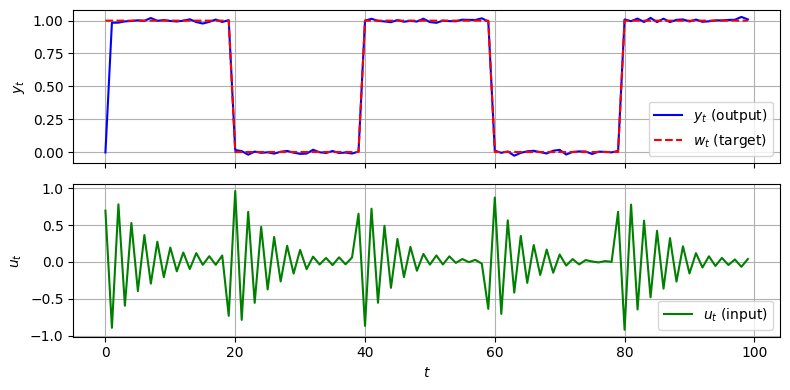

In [872]:
import numpy as np
N = 100 # num timesteps
# initialize w_t, y_t and u_t
w = np.ones(N)
y = np.zeros(N)
u = np.zeros(N)
np.random.seed(33)
noise = np.random.normal(0, 1e-2, size=N)

# initialize w
for t in range(N):
    # set w_t
    if (t // 20) % 2 == 1:
        w[t] = 0
        
# simulation
for t in range(N): 
    # calculate y_t
    for i in range(1,len(A)):
        y[t] -= A[i] * y[t-i]
    for i in range(len(B)):
        y[t] += B[i] * u[t-i-k]
    y[t] += noise[t] # add noise

    # Use MV_0 to get u_t
    if t + 1 < 100: u[t] = w[t+1]
    else: u[t] = w[t]
    for i in range(len(S)):
        u[t] -= S[i] * y[t-i]
    for i in range(1,len(BG)):
        u[t] -= BG[i] * u[t-i]
    u[t] /= BG[0]


# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].plot(w, label='$w_t$ (target)', color='red', linestyle='--')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='lower right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

# save for later
J_r = np.cumsum((y-w)**2)
J_u = np.cumsum(u**2)
J_e = np.cumsum(noise**2)


## Question 1.2

In [873]:
# re-initialize y_t and u_t
y = np.zeros(N)
u = np.zeros(N)

def get_phi(i):
    return np.array([-y[i-1], -y[i-2], -y[i-3], u[i-1], u[i-2], u[i-3]])


theta = np.zeros([N,6])
phi = np.zeros([N,6])

# initial theta: true params + noise
theta[-1] = A[1:] + B #true params
epsilon = np.zeros(N) # initialize errors
theta_true = np.array(A[1:] + B)
P = np.zeros([N,6,6])
q = 0.8
P[-1] = np.identity(6)


# simulation 
for t in range(N):
    # simulate y
    phi = get_phi(t)
    y[t] = np.dot(phi,theta_true) + noise[t] # add noise

    # Estimate error
    epsilon[t] = y[t] - np.dot(phi,theta[t-1])
    # Get Kalman gain
    s = 1 + phi[None, :] @ P[t-1] @ phi[:,None]
    K = P[t-1] @ phi[:,None] * (1/s)
    # Update params
    theta[t] = theta[t-1] + K.squeeze() * epsilon[t]
    P[t] = P[t-1] - s * K @ K.T

    temp = get_phi(t+1)
    temp[3] = 0
    if t < N-1:
        u[t] = w[t+1]/theta[t,3] - np.dot(theta[t],temp) / theta[t,3]



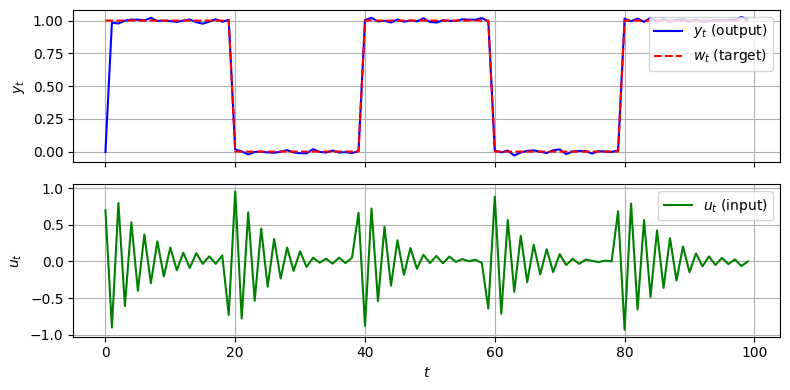

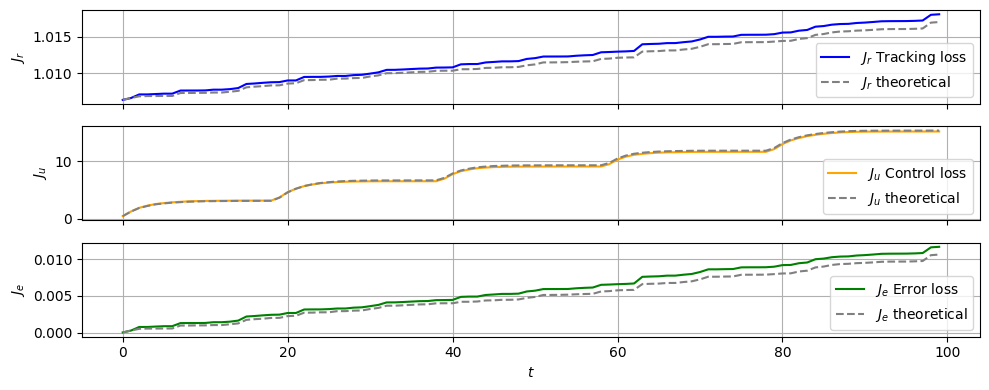

In [874]:
# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].plot(w, label='$w_t$ (target)', color='red', linestyle='--')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='upper right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

# Plot using subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
axs[0].plot(np.cumsum((y-w)**2), label='$J_r$ Tracking loss', color='blue')
axs[0].plot(J_r, label='$J_r$ theoretical',color='grey', linestyle = '--')
axs[0].set_ylabel("$J_r$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(np.cumsum(u**2), label='$J_u$ Control loss', color='orange')
axs[1].plot(J_u, label='$J_u$ theoretical', color='grey', linestyle = '--')
axs[1].legend(loc='lower right')
axs[1].set_ylabel("$J_u$")
axs[1].grid()

axs[2].plot(np.cumsum(epsilon**2), label='$J_e$ Error loss', color='green')
axs[2].plot(J_e, label='$J_e$ theoretical', color='grey', linestyle = '--')
axs[2].legend(loc='lower right')
axs[2].set_ylabel("$J_e$")
axs[2].set_xlabel("$t$")
axs[2].grid()
plt.tight_layout()
plt.show()



## Question 1.3

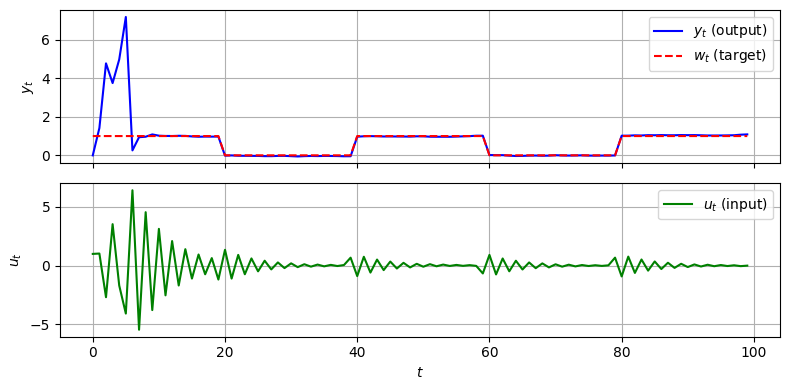

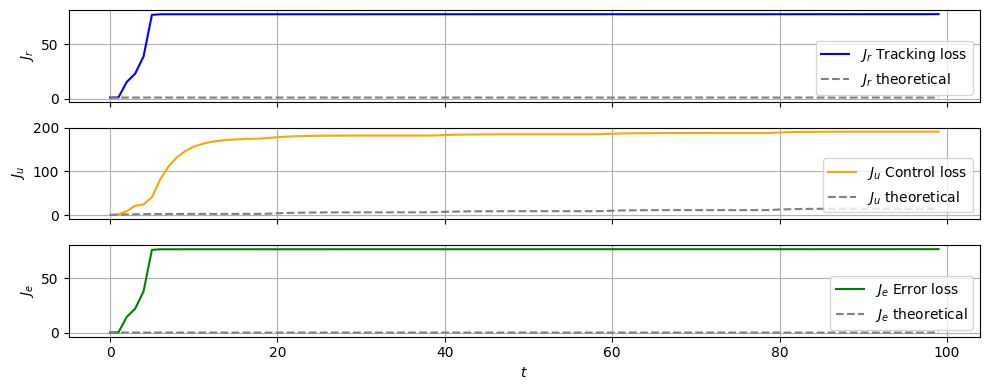

In [875]:
N = 100 # num timesteps
# initialize w_t, y_t and u_t
w = np.ones(N)
y = np.zeros(N)
u = np.zeros(N)

# simulation 
for t in range(N):
    # set w_t
    if (t // 20) % 2 == 1:
        w[t] = 0

def get_phi(i):
    return np.array([-y[i-1], -y[i-2], -y[i-3], u[i-1], u[i-2], u[i-3]])


theta = np.zeros([N,6])
phi = np.zeros([N,6])

# initial theta: true params + noise
theta_true = np.array(A[1:] + B) #true params
theta[-1] = np.ones_like(theta_true)
epsilon = np.zeros(N) # initialize errors
P = np.zeros([N,6,6])
P[-1] = np.identity(6)*10


# simulation 
for t in range(N):
    # simulate y
    phi = get_phi(t)
    y[t] = np.dot(phi,theta_true) + noise[t] # add noise

    # Estimate error
    epsilon[t] = y[t] - np.dot(phi,theta[t-1])
    # Get Kalman gain
    s = 1 + phi[None, :] @ P[t-1] @ phi[:,None]
    K = P[t-1] @ phi[:,None] * (1/s)
    # Update params
    theta[t] = theta[t-1] + K.squeeze() * epsilon[t]
    P[t] = P[t-1] - s * K @ K.T

    temp = get_phi(t+1)
    temp[3] = 0

    if t < N-1:
        u[t] = w[t+1]/theta[t,3] - np.dot(theta[t],temp) / theta[t,3]


# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].plot(w, label='$w_t$ (target)', color='red', linestyle='--')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='upper right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

# Plot using subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
axs[0].plot(np.cumsum((y-w)**2), label='$J_r$ Tracking loss', color='blue')
axs[0].plot(J_r, label='$J_r$ theoretical',color='grey', linestyle = '--')
axs[0].set_ylabel("$J_r$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(np.cumsum(u**2), label='$J_u$ Control loss', color='orange')
axs[1].plot(J_u, label='$J_u$ theoretical', color='grey', linestyle = '--')
axs[1].legend(loc='lower right')
axs[1].set_ylabel("$J_u$")
axs[1].grid()

axs[2].plot(np.cumsum(epsilon**2), label='$J_e$ Error loss', color='green')
axs[2].plot(J_e, label='$J_e$ theoretical', color='grey', linestyle = '--')
axs[2].legend(loc='lower right')
axs[2].set_ylabel("$J_e$")
axs[2].set_xlabel("$t$")
axs[2].grid()
plt.tight_layout()
plt.show()

# Part 2
## Question 2.1

In [877]:
A = [1, -2.438, 1.942,-0.502]
B = [1.446,-0.158,-1.093]
C = [1, -1.441, 0.296, 0.167] # <- coeffs of C
k = 1

## Question 2.2

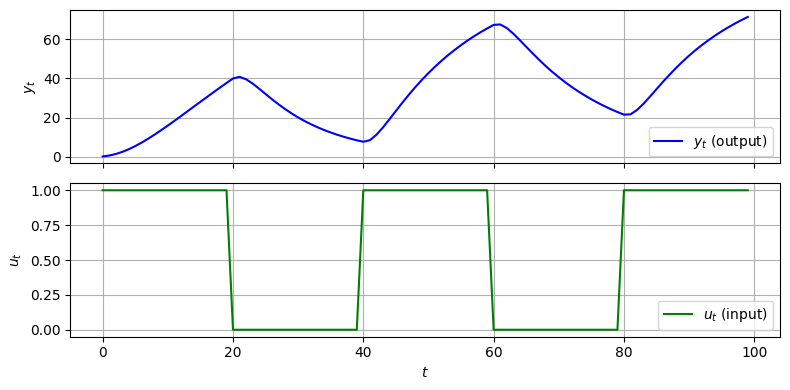

In [878]:
def sim_ARMAX(A, B, C, k, u, e = None, N=100):
    if e is None:
        e = np.random.normal(scale=1e-2,size=N)
    y = np.zeros(N)

    # simulation
    for t in range(N): 
        # calculate y_t
        for i in range(1,len(A)):
            y[t] -= A[i] * y[t-i]
        for i in range(len(B)):
            y[t] += B[i] * u[t-i-k]
        for i in range(len(C)):
            y[t] += C[i] * e[t-i]
            
    return y

N = 100
u = np.ones(N)
# initialize w
for t in range(N):
    # set w_t
    if (t // 20) % 2 == 1:
        u[t] = 0

y = sim_ARMAX(A,B,C,k,u,e = noise, N=100)

# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='lower right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

## Question 2.3

In [879]:
# Solve diophantine
def solve_diophantine(A,C,m):
    G = []
    S = C[:] + [0 for _ in range(len(A)-len(C))]

    for i in range(m):
        G.append(S[0])
        S = [S[j] - S[0] * A[j] for j in range(1, len(S))] + [0]

    S = S[:-1]
    return S, G

S, G = solve_diophantine(A,C,m=1)
print('S =',S)
print('G =',G)

S = [0.9970000000000001, -1.646, 0.669]
G = [1]


# Question 2.4

In [880]:
import numpy as np
from numpy.polynomial import polynomial as P

def solve_diophantine(A, C, m):
    """
    Solves the Diophantine equation:
        C(q⁻¹) = A(q⁻¹) · G(q⁻¹) + q⁻ᵐ · S(q⁻¹)

    Parameters:
    A : list or array-like
        Coefficients of the polynomial A(q⁻¹)
    C : list or array-like
        Coefficients of the polynomial C(q⁻¹)
    m : int
        Delay (i.e., the number of leading terms to extract in G)

    Returns:
    S : list
        Coefficients of the polynomial S(q⁻¹)
    G : list
        Coefficients of the polynomial G(q⁻¹), length = m
    """
    
    G = []
    if len(C) < len(A): # case degree C < degree A
        S = list(C) + [0 for _ in range(len(A)-len(C))] # pad with zeros
    else: # case degree A < degree C
        S = C
        A = list(A) + [0 for _ in range(len(C)-len(A))] # pad with zeros

    for i in range(m):
        G.append(S[0])
        S = [S[j] - S[0] * A[j] for j in range(1, len(S))] + [0]

    S = S[:-1]
    return S, G

S, G = solve_diophantine(A,C,m=1)

def get_GMV_poly(A, B, C, Ay=None, By=None, Hw=None, Au=None, Bu=None, rho=1.0):
    """
    Compute polynomials R(q⁻¹), Q(q⁻¹), S(q⁻¹) for the Generalized Minimum Variance (GMV) control law:
        R(q⁻¹) u_t = Q(q⁻¹) w_t - S(q⁻¹) y_t

    The GMV control law is derived using the Diophantine equation, and the resulting polynomials 
    are computed based on ARMAX system coefficients, transfer functions, and control parameters.

    Parameters:
    A, B, C : list or np.array
        Polynomials of the ARMAX model where A, B, and C represent coefficients 
        of the system equation (A q⁻¹ y_t = B q⁻¹ u_t + C q⁻¹ e_t).
    Ay, By : list, optional
        Polynomials of the reference system (typically Ay = 1, By = 1 for simple cases).
    Hw : list, optional
        Transfer function of the setpoint w_t (default is [1] which means no filtering).
    Au, Bu : list, optional
        Polynomials of the control input system (default values represent a first-order difference).
    rho : float, optional
        Control effort weighting parameter (default = 1.0), affecting the trade-off between control effort 
        and tracking error.

    Returns:
    R, Q, S : np.array
        Polynomials for the GMV controller, where:
        - R(q⁻¹) is the controller’s transfer function for the control input.
        - Q(q⁻¹) is the transfer function for the reference input w_t.
        - S(q⁻¹) is the transfer function for the output feedback y_t.
    """

    # Default settings for MV1a controller if not provided
    if Ay is None:
        Ay = [1]  # Default to no modification for Ay (i.e., Ay = 1)
    if By is None:
        By = [1]  # Default to no modification for By (i.e., By = 1)
    if Hw is None:
        Hw = [1]  # Default setpoint transfer function (no modification)
    if Bu is None:
        Bu = [1, -1]  # Default to (1 - q⁻¹) for control input transfer function
    if Au is None:
        Au = [1]  # Default to no modification for Au (i.e., Au = 1)

    # Solve the Diophantine equation: Aᵧ(q⁻¹) * A(q⁻¹) * G(q⁻¹) + q⁻¹ * S(q⁻¹) = Bᵧ(q⁻¹) * C(q⁻¹)
    S, G = solve_diophantine(P.polymul(Ay, A), P.polymul(By, C), 1)

    # Compute the polynomial R(q⁻¹): Au*B*G + (rho / B0) * C*Bu
    R = P.polyadd(P.polymul(Au, P.polymul(B, G)), (rho / B[0]) * P.polymul(C, Bu))

    # Compute the polynomial Q(q⁻¹): Au * (Hw * C)
    Q = P.polymul(Au, P.polymul(C, Hw))

    # Compute the polynomial S(q⁻¹): -Au * (S / Ay) [Note that remainder of poly-division is removed]
    S = -P.polymul(Au, P.polydiv(S, Ay)[0])
    
    return R, Q, S
    

R=[ 2.13756293 -1.84610512  0.10824481 -0.08921162 -0.11549101]
Q=[ 1.    -1.441  0.296  0.167]
S=[-0.997  1.646 -0.669]


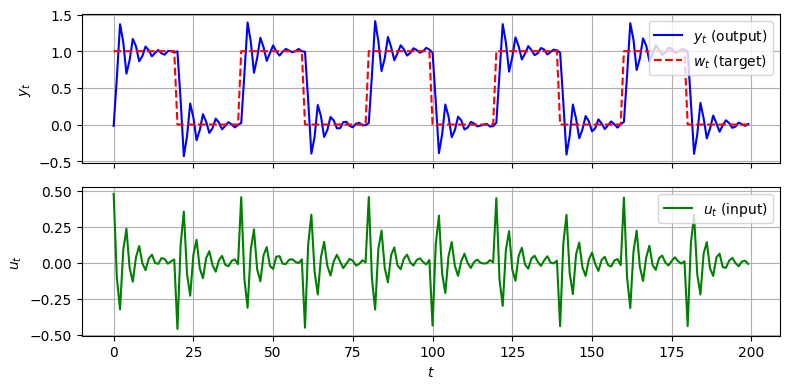

In [881]:
A = [1,-2.438, 1.942,-0.502]
B = [1.446,-0.158,-1.093]
C = [1, -1.441, 0.296, 0.167]
k = 1

R, Q, S = get_GMV_poly(A, B, C)
print(f'R={R}')
print(f'Q={Q}')
print(f'S={S}')

N = 200 # num timesteps
# initialize y_t, u_t and noise signal
y = np.zeros(N)
u = np.zeros(N)
np.random.seed(33)
noise = np.random.normal(0, 1e-2, size=N)

# initialize w_t 
w = np.ones(N)
for t in range(N):
    # set w_t
    if (t // 20) % 2 == 1:
        w[t] = 0
# simulation
for t in range(N): 
    # calculate y_t
    for i in range(1,len(A)):
        y[t] -= A[i] * y[t-i]
    for i in range(len(B)):
        y[t] += B[i] * u[t-i-k]
    for i in range(len(C)):
        y[t] += C[i] * noise[t-i] 

    # calculate u_t
    for i in range(1,len(R)):
        u[t] -= R[i] * u[t-i]
    for i in range(len(Q)):
        u[t] += Q[i] * w[t-i]
    for i in range(len(S)):
        u[t] += S[i] * y[t-i]
    u[t] = u[t] / R[0]

# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].plot(w, label='$w_t$ (target)', color='red', linestyle='--')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='upper right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

# save for later
J_r = np.cumsum((y-w)**2)
J_u = np.cumsum(u**2)
J_e = np.cumsum(noise**2)

# Question 2.6

Generate u(t) from PRBS

In [882]:
def prbs(N, seed=1, taps=[10, 1]):
    """
    Generate a PRBS of length N using an LFSR.

    Args:
        N (int): Length of the PRBS sequence.
        seed (int): Initial value of the shift register.
        taps (list): Feedback taps (0-based index).

    Returns:
        np.array: PRBS sequence of length N.
    """
    # Number of bits in the shift register (from the largest tap index)
    m = max(taps) + 1
    # Convert seed to binary array with length m
    state = np.array([int(x) for x in np.binary_repr(seed, width=m)])
    sequence = []

    for _ in range(N):
        sequence.append(state[-1])  # Output the last bit
        # XOR feedback taps
        feedback = np.bitwise_xor.reduce(state[taps])
        # Shift register and insert feedback
        state = np.roll(state, 1)
        state[0] = feedback

    return np.array(sequence)
N = 200
u = prbs(N+10)[10:]


use u(t) to estimate system params by RELS-estimation

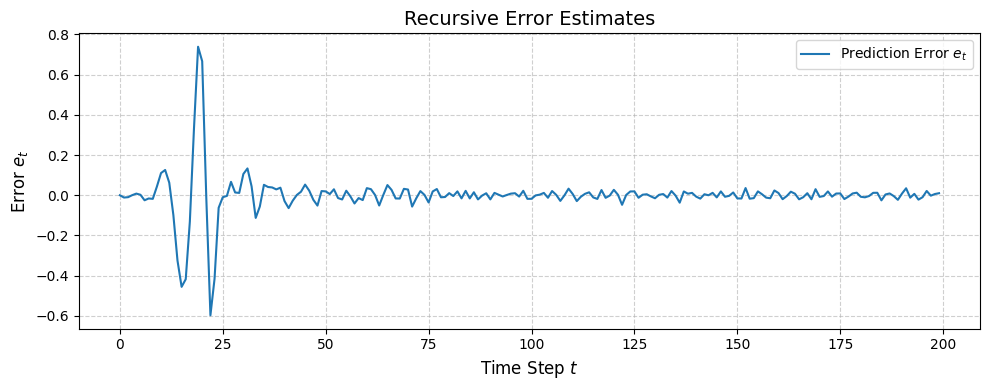

In [883]:
A = [1,-2.438, 1.942,-0.502]
B = [1.446,-0.158,-1.093]
C = [1, -1.441, 0.296, 0.167]
k = 1

# initialize y, e and noise
y = np.zeros(N)
e = np.zeros(N)

theta_star = np.zeros((N,9))
# identity matrix as covarince structure
P_inv = np.zeros((N,9,9))
P_inv[0] = np.identity(9)

np.random.seed(33)
noise = np.random.normal(0, 1e-2, size=N)
def phi_star(t):
    return np.array([
        -y[t-1] if t-1 >= 0 else 0,
        -y[t-2] if t-2 >= 0 else 0,
        -y[t-3] if t-3 >= 0 else 0,
        u[t-1] if t-1 >= 0 else 0,
        u[t-2] if t-2 >= 0 else 0,
        u[t-3] if t-3 >= 0 else 0,
        e[t-1] if t-1 >= 0 else 0,
        e[t-2] if t-2 >= 0 else 0,
        e[t-3] if t-3 >= 0 else 0
    ])

def phi(t):
    return np.array([
        -y[t-1] if t-1 >= 0 else 0,
        -y[t-2] if t-2 >= 0 else 0,
        -y[t-3] if t-3 >= 0 else 0,
        u[t-1] if t-1 >= 0 else 0,
        u[t-2] if t-2 >= 0 else 0,
        u[t-3] if t-3 >= 0 else 0,
        noise[t] if t >= 0 else 0,
        noise[t-1] if t-1 >= 0 else 0,
        noise[t-2] if t-2 >= 0 else 0,
        noise[t-3] if t-3 >= 0 else 0
    ])

theta = np.array([A[1], A[2], A[3], B[0], B[1], B[2], C[0], C[1], C[2], C[3]])
# initial guess = true params
theta_star[0] = np.array([A[1], A[2], A[3], B[0], B[1], B[2], C[1], C[2], C[3]])

for t in range(N):
    y[t] = np.dot(theta,phi(t))

    if t > 0:
        e[t] = y[t] - np.dot(theta_star[t-1], phi_star(t))
        P_inv[t] = P_inv[t-1] + phi_star(t).reshape(-1,1) @ phi_star(t).reshape(1,-1)
        theta_star[t] = theta_star[t-1] + np.linalg.solve(P_inv[t],phi_star(t))*e[t]



plt.figure(figsize=(10, 4))
plt.plot(e, label='Prediction Error $e_t$', color='tab:blue', linewidth=1.5)
plt.title('Recursive Error Estimates', fontsize=14)
plt.xlabel('Time Step $t$', fontsize=12)
plt.ylabel('Error $e_t$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

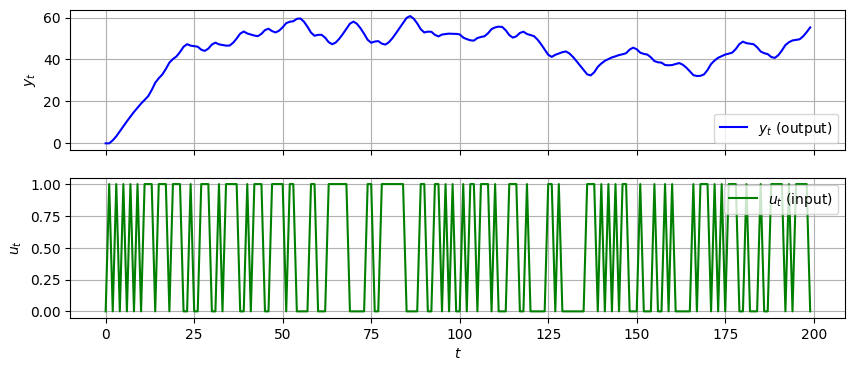

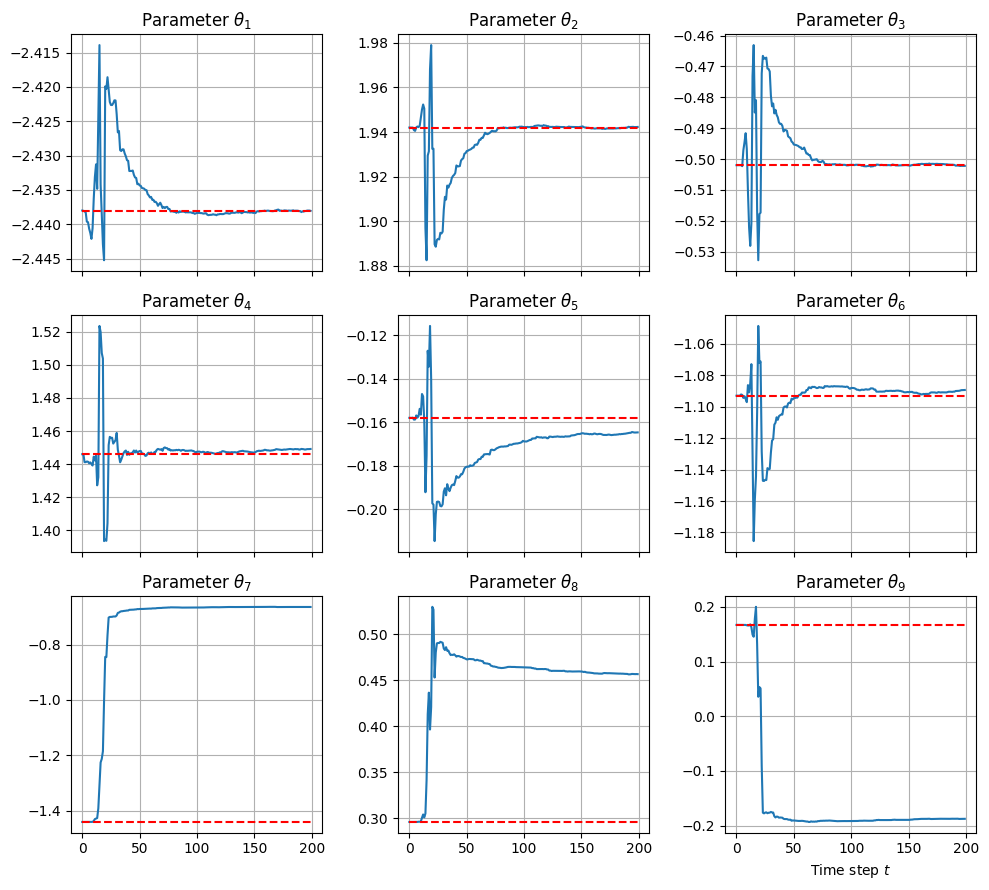

In [884]:
# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()


fig, axs = plt.subplots(3, 3, figsize=(10, 9), sharex=True)
axs = axs.flatten()

t_range = np.arange(theta_star.shape[0])

for i in range(9):
    axs[i].plot(t_range, theta_star[:, i], label=r'$\hat{\theta}_{%d}(t)$' % (i+1))
    axs[i].hlines(theta_star[0, i], xmin=0, xmax=len(t_range)-1, colors='red', linestyles='--', label=r'$\theta_{%d}^{\mathrm{true}}$' % (i+1))
    axs[i].set_title(r'Parameter $\theta_{%d}$' % (i+1))
    axs[i].grid()

plt.xlabel("Time step $t$")
plt.tight_layout()
plt.show()

# Question 2.7

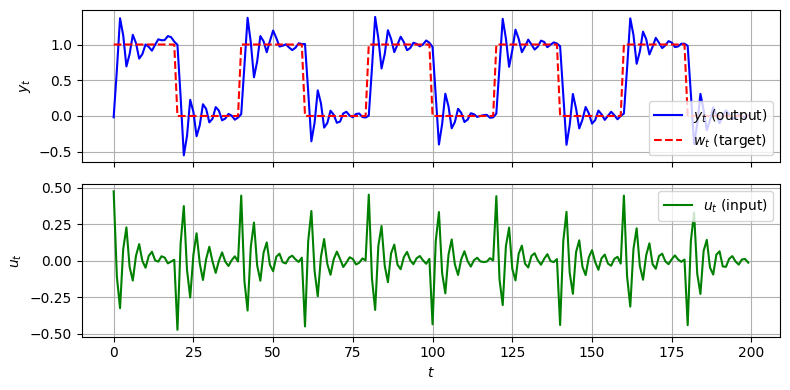

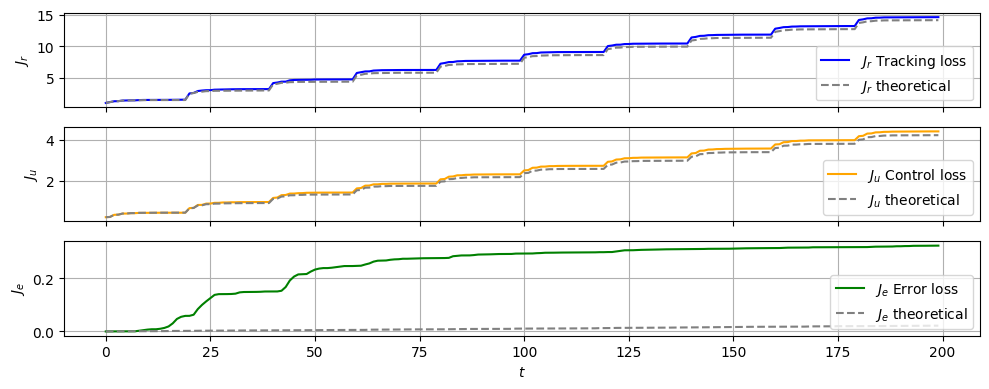

In [885]:
A = [1,-2.438, 1.942,-0.502]
B = [1.446,-0.158,-1.093]
C = [1, -1.441, 0.296, 0.167]
k = 1
R, Q, S = get_GMV_poly(A, B, C)

N = 200 # num timesteps
theta = np.zeros((N,9))
theta[0] = A[1:] + B + C[1:]
P_inv = np.zeros((N,9,9))
P_inv[0] = np.identity(9)
# initialize y_t, u_t and noise signal
y = np.zeros(N)
u = np.zeros(N)
np.random.seed(33)
noise = np.random.normal(0, 1e-2, size=N)

# initialize w_t 
w = np.ones(N)
for t in range(N):
    # set w_t
    if (t // 20) % 2 == 1:
        w[t] = 0
# simulation
for t in range(N): 
    # calculate y_t
    for i in range(1,len(A)):
        y[t] -= A[i] * y[t-i]
    for i in range(len(B)):
        y[t] += B[i] * u[t-i-k]
    for i in range(len(C)):
        y[t] += C[i] * noise[t-i] 

    if t > 0:
        e[t] = y[t] - np.dot(theta[t-1], phi_star(t))
        P_inv[t] = P_inv[t-1] + phi_star(t).reshape(-1,1) @ phi_star(t).reshape(1,-1)
        theta[t] = theta[t-1] + np.linalg.solve(P_inv[t],phi_star(t))*e[t]

    # calculate u_t
    R, Q, S = get_GMV_poly(A = [1]+ list(theta[t][:3]), B =list(B), C =[1]+ list(theta[t][-3:]))
    for i in range(1,len(R)):
        u[t] -= R[i] * u[t-i]
    for i in range(len(Q)):
        u[t] += Q[i] * w[t-i]
    for i in range(len(S)):
        u[t] += S[i] * y[t-i]
    u[t] = u[t] / R[0]


# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].plot(w, label='$w_t$ (target)', color='red', linestyle='--')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

# Plot using subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
axs[0].plot(np.cumsum((y-w)**2), label='$J_r$ Tracking loss', color='blue')
axs[0].plot(J_r, label='$J_r$ theoretical',color='grey', linestyle = '--')
axs[0].set_ylabel("$J_r$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(np.cumsum(u**2), label='$J_u$ Control loss', color='orange')
axs[1].plot(J_u, label='$J_u$ theoretical', color='grey', linestyle = '--')
axs[1].legend(loc='lower right')
axs[1].set_ylabel("$J_u$")
axs[1].grid()

axs[2].plot(np.cumsum(e**2), label='$J_e$ Error loss', color='green')
axs[2].plot(J_e, label='$J_e$ theoretical', color='grey', linestyle = '--')
axs[2].legend(loc='lower right')
axs[2].set_ylabel("$J_e$")
axs[2].set_xlabel("$t$")
axs[2].grid()
plt.tight_layout()
plt.show()

# Question 2.8

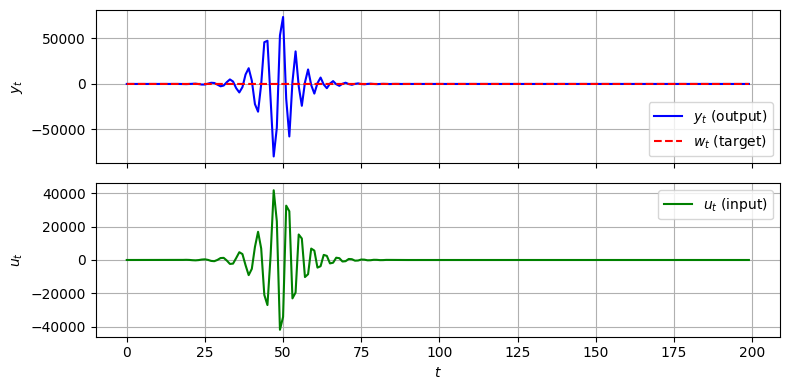

In [886]:
A = [1,-2.438, 1.942,-0.502]
B = [1.446,-0.158,-1.093]
C = [1, -1.441, 0.296, 0.167]
k = 1

N = 200 # num timesteps
theta = np.zeros((N,9))
theta[0] = np.ones(9)
P_inv = np.zeros((N,9,9))
P_inv[0] = np.identity(9)/1000
# initialize y_t, u_t and noise signal
y = np.zeros(N)
u = np.zeros(N)
np.random.seed(33)
noise = np.random.normal(0, 1e-2, size=N)

# initialize w_t 
w = np.ones(N)
for t in range(N):
    # set w_t
    if (t // 20) % 2 == 1:
        w[t] = 0
# simulation
for t in range(N): 
    # calculate y_t
    for i in range(1,len(A)):
        y[t] -= A[i] * y[t-i]
    for i in range(len(B)):
        y[t] += B[i] * u[t-i-k]
    for i in range(len(C)):
        y[t] += C[i] * noise[t-i] 

    if t > 0:
        e[t] = y[t] - np.dot(theta[t-1], phi_star(t))
        P_inv[t] = P_inv[t-1] + phi_star(t).reshape(-1,1) @ phi_star(t).reshape(1,-1)
        theta[t] = theta[t-1] + np.linalg.solve(P_inv[t],phi_star(t))*e[t]

    # calculate u_t
    R, Q, S = get_GMV_poly(A = [1]+ list(theta[t][:3]), B =list(B), C =[1]+ list(theta[t][-3:]))
    for i in range(1,len(R)):
        u[t] -= R[i] * u[t-i]
    for i in range(len(Q)):
        u[t] += Q[i] * w[t-i]
    for i in range(len(S)):
        u[t] += S[i] * y[t-i]
    u[t] = u[t] / R[0]


# Plot using subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(y, label='$y_t$ (output)', color='blue')
axs[0].plot(w, label='$w_t$ (target)', color='red', linestyle='--')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(u, label='$u_t$ (input)', color='g')
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

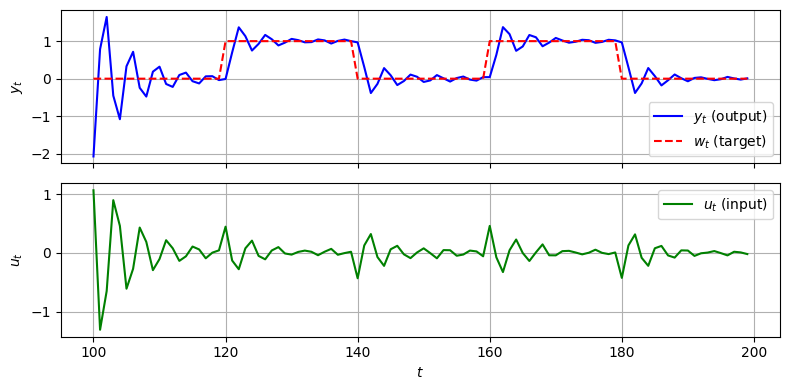

In [887]:
# Plot using subplots
t = np.arange(100,200)
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axs[0].plot(t,y[100:], label='$y_t$ (output)', color='blue')
axs[0].plot(t,w[100:], label='$w_t$ (target)', color='red', linestyle='--')
axs[0].set_ylabel("$y_t$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(t,u[100:], label='$u_t$ (input)', color='g')
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$u_t$")
axs[1].set_xlabel("$t$")
axs[1].grid()

plt.tight_layout()
plt.show()

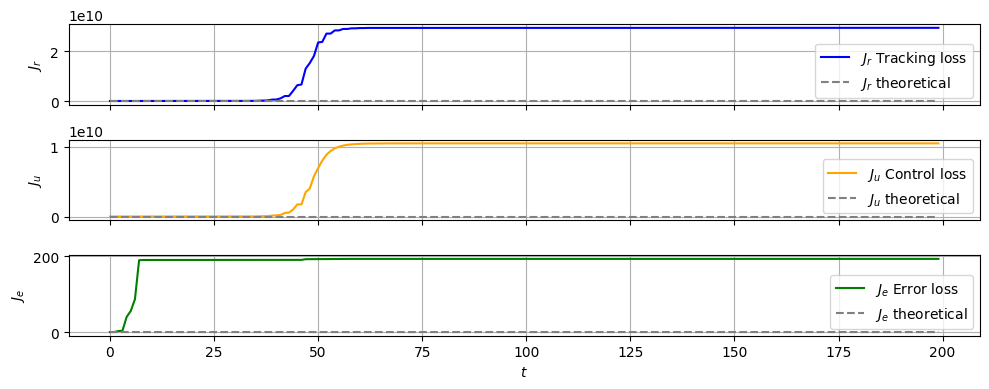

In [888]:
# Plot using subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
axs[0].plot(np.cumsum((y-w)**2), label='$J_r$ Tracking loss', color='blue')
axs[0].plot(J_r, label='$J_r$ theoretical',color='grey', linestyle = '--')
axs[0].set_ylabel("$J_r$")
axs[0].legend(loc='lower right')
axs[0].grid()

axs[1].plot(np.cumsum(u**2), label='$J_u$ Control loss', color='orange')
axs[1].plot(J_u, label='$J_u$ theoretical', color='grey', linestyle = '--')
axs[1].legend(loc='lower right')
axs[1].set_ylabel("$J_u$")
axs[1].grid()

axs[2].plot(np.cumsum(e**2), label='$J_e$ Error loss', color='green')
axs[2].plot(J_e, label='$J_e$ theoretical', color='grey', linestyle = '--')
axs[2].legend(loc='lower right')
axs[2].set_ylabel("$J_e$")
axs[2].set_xlabel("$t$")
axs[2].grid()
plt.tight_layout()
plt.show()

# Appendix

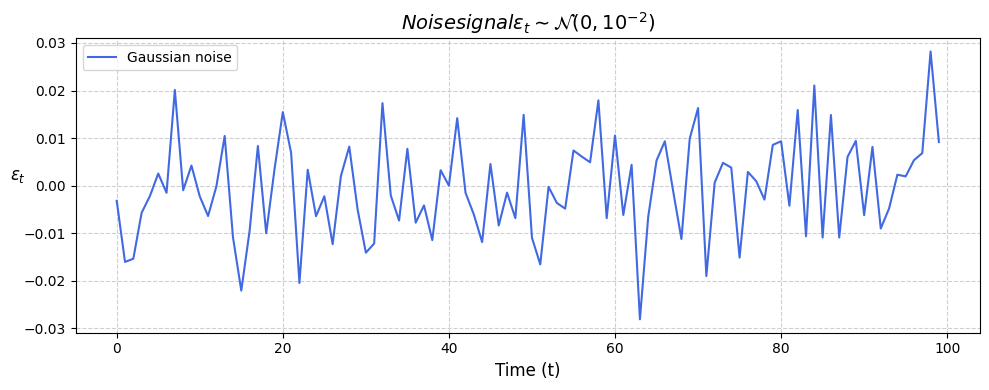

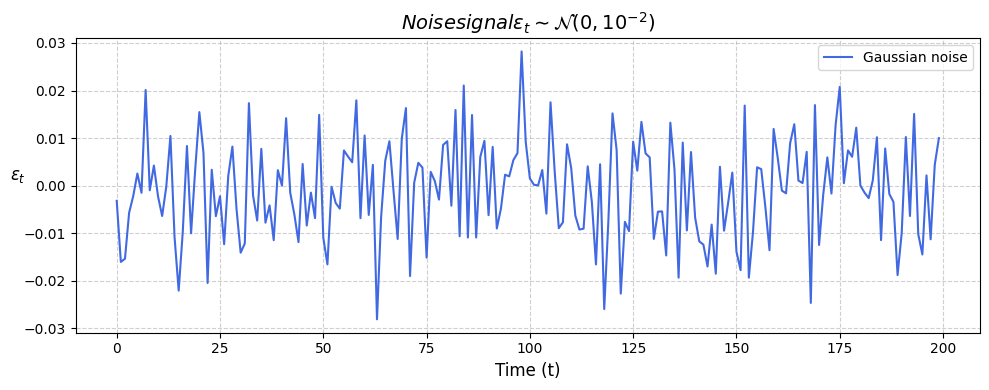

In [889]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(33)
N = 100  # Make sure N is defined
noise = np.random.normal(0, 1e-2, size=N)

plt.figure(figsize=(10, 4))
plt.plot(noise, color='royalblue', linewidth=1.5, label='Gaussian noise')
plt.title(r'$Noise signal \epsilon_t\sim \mathcal{N}(0,10^{-2})$', fontsize=14)
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel(r'$\epsilon_t$', fontsize=12, rotation = 0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

np.random.seed(33)
N = 200  # Make sure N is defined
noise = np.random.normal(0, 1e-2, size=N)

plt.figure(figsize=(10, 4))
plt.plot(noise, color='royalblue', linewidth=1.5, label='Gaussian noise')
plt.title(r'$Noise signal \epsilon_t\sim \mathcal{N}(0,10^{-2})$', fontsize=14)
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel(r'$\epsilon_t$', fontsize=12, rotation = 0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

